In [ ]:
#importing libraries
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
import numpy as np
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA

#importing dataset
data = pd.read_csv("geocode_coordinates.csv")

#cleaning dataset
data["quarter"] = pd.to_datetime(data["quarter"])                   #converting "quarter" to pandas datetime
data.set_index("quarter", inplace=True)                             #setting quarter to index
data["avg"] = round((data["onebhk"] + data["twobhk"] + data["threebhk"]) / 3, 2)
data = data.drop(data.columns[[0, 2, 3, 4, 5, 6, 7, 8, 9, 10]], axis = 1)   #dropping extra columns

print(data.head())
city = "Ahmedabad"

df = data[data["city"] == city]           #filtering out data based on city
df = df.asfreq("QS-JUN")                  #setting frequency of data to Quarterly and initialising it to JUNE
print(df.head())

# df.to_csv("city.csv")

                 city      avg
quarter                       
2013-06-01  Ahmedabad  3337.67
2013-09-01  Ahmedabad  3331.67
2013-12-01  Ahmedabad  3291.67
2014-03-01  Ahmedabad  3259.67
2014-06-01  Ahmedabad  3287.33
                 city      avg
quarter                       
2013-06-01  Ahmedabad  3337.67
2013-09-01  Ahmedabad  3331.67
2013-12-01  Ahmedabad  3291.67
2014-03-01  Ahmedabad  3259.67
2014-06-01  Ahmedabad  3287.33


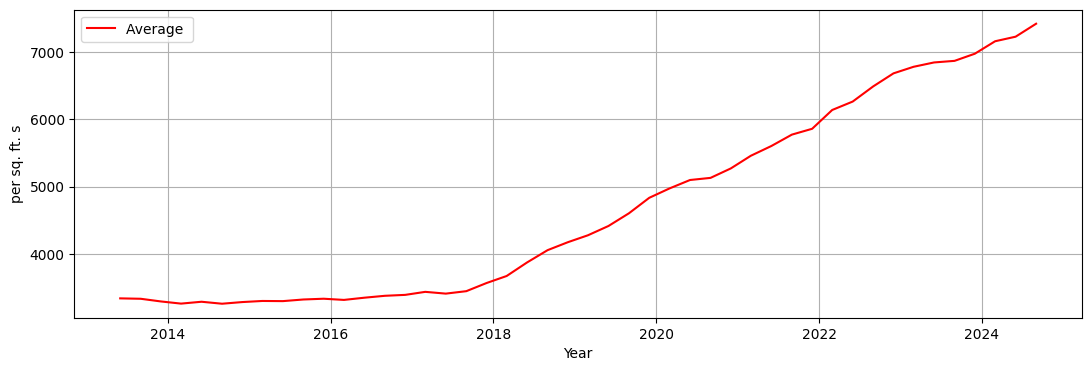

In [19]:
plt.figure(figsize = (13, 4))
plt.plot(df.index, df["avg"], label = "Average ", color = "red")
plt.xlabel("Year")
plt.ylabel("per sq. ft. s")
plt.legend()
plt.grid(True)
plt.show()

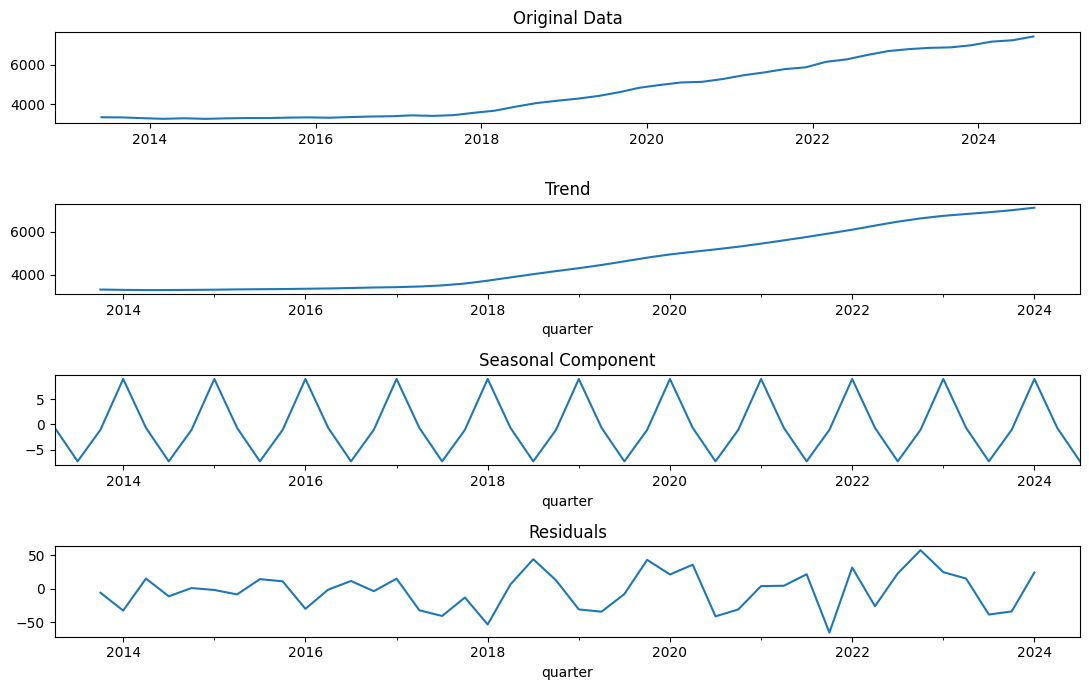

In [20]:
# seasonal decompose
result = seasonal_decompose(df["avg"], model = "additive", period = 4)

plt.figure(figsize = (11, 7))

plt.subplot(4, 1, 1)                                        # 4 rows, 1 column, 1st plot
plt.plot(df['avg'], label='Original Data')
plt.title('Original Data')

# Plot the trend
plt.subplot(4, 1, 2)                                        # 4 rows, 1 column, 2nd plot
result.trend.plot()
plt.title('Trend')

# Plot the seasonal component
plt.subplot(4, 1, 3)                                        # 4 rows, 1 column, 3rd plot
result.seasonal.plot()
plt.title('Seasonal Component')

# Plot the residual component
plt.subplot(4, 1, 4)                                        # 4 rows, 1 column, 4th plot
result.resid.plot()
plt.title('Residuals')

# Adjust layout to prevent overlap
plt.tight_layout()

In [21]:
# Using Adefuller Test to check for stationarity
def get_adfuller(data):
    result = adfuller(data)
    print('ADF Statistic:', round(result[0], 4))
    print('p-value:', round(result[1], 4))
    if result[1] < 0.05:
        print("The data is stationary.")
    else:
        print("The data is non-stationary.")
    print("\n")
    return result

ADF results for Log Transformed Data
ADF Statistic: 0.808
p-value: 0.9918
The data is non-stationary.


ADF results for First Order Differenced Data
ADF Statistic: -3.1411
p-value: 0.0237
The data is stationary.


ADF results for Second Order Differenced Data
ADF Statistic: -5.4896
p-value: 0.0
The data is stationary.




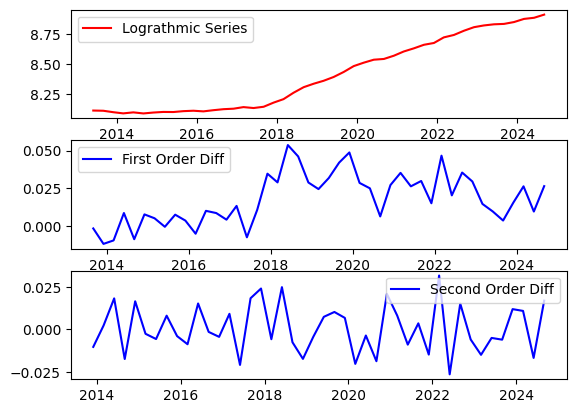

In [22]:
# Applying log transformation
df.loc[:, "Log"] = np.log(df["avg"])

#applying differencing on log-transformed data
df.loc[:, "LogDiff1"] = df["Log"].diff()
df.loc[:, "LogDiff2"] = df["LogDiff1"].diff()

print("ADF results for Log Transformed Data")
get_adfuller(df["Log"])

print("ADF results for First Order Differenced Data")
get_adfuller(df["LogDiff1"].dropna())

print("ADF results for Second Order Differenced Data")
get_adfuller(df["LogDiff2"].dropna())


plt.Figure(figsize=(10, 7))

plt.subplot(3, 1, 1)                                       
plt.plot(df["Log"], label = "Lograthmic Series", color = "red")
plt.legend()

plt.subplot(3, 1, 2)                                       
plt.plot(df["LogDiff1"], label = "First Order Diff", color = "blue")
plt.legend()

plt.subplot(3, 1, 3)                                       
plt.plot(df["LogDiff2"], label = "Second Order Diff", color = "blue")
plt.legend()

plt.show()


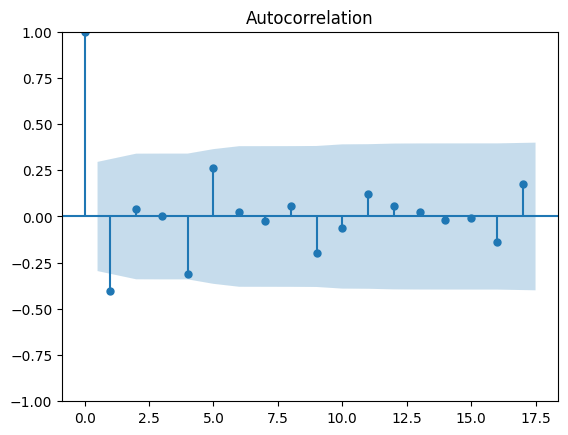

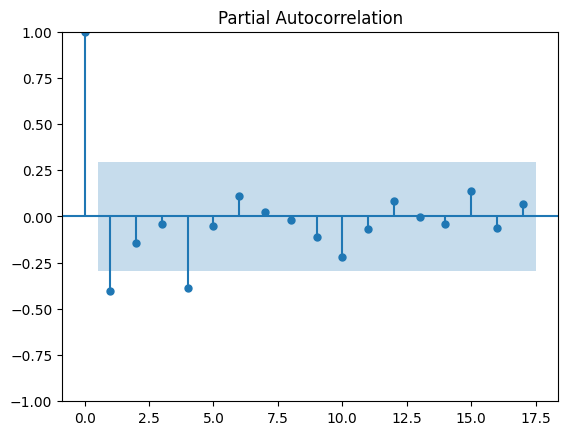

In [23]:
#ACF & PCF Testing

# Plot ACF
plot_acf(df["LogDiff2"].dropna())
plt.show()

# Plot PACF
plot_pacf(df["LogDiff2"].dropna())
plt.show()

In [24]:
# Training ARIMA Model on dataset
model = ARIMA(df["LogDiff1"].dropna(), order = (1, 0, 1)).fit()

#forecasting next 4 quarters
forecast_steps = 4
forecast = model.forecast(steps = forecast_steps)

#reversing second differencing 
LastVal_LogDiff1 = df["LogDiff2"].iloc[-1]
Undiff2 = LastVal_LogDiff1 + forecast.cumsum()

#reversing first differencing 
LastVal_Log = df["Log"].iloc[-1]
Undiff1 = LastVal_Log + Undiff2.cumsum()

#inversing log transformation 
final_forecast = np.exp(Undiff1)
# print(df)
print(final_forecast)

2024-12-01    7702.862666
2025-03-01    8147.806835
2025-06-01    8783.032234
2025-09-01    9644.710320
Freq: QS-JUN, Name: predicted_mean, dtype: float64


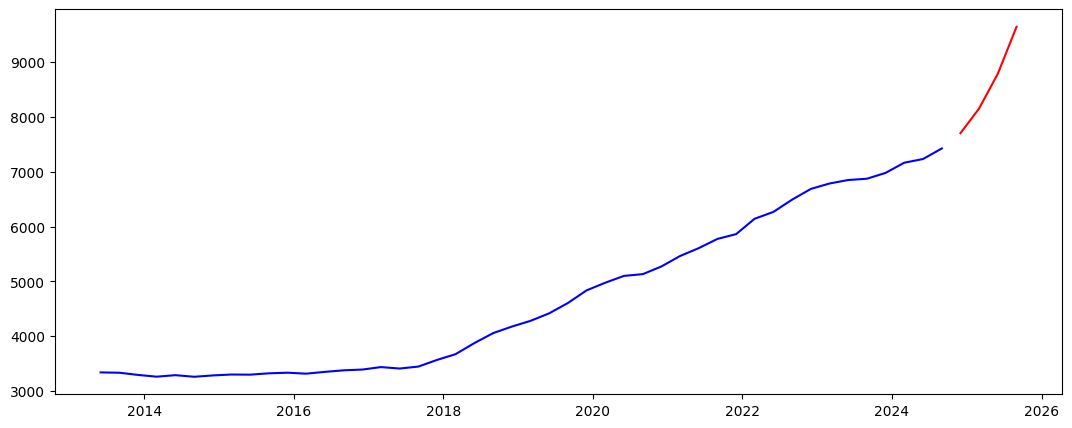

In [25]:
#visualising final forecast

plt.figure(figsize=(13, 5))
plt.plot(df.index, df["avg"], label = "Historic Data", color = "blue")
plt.plot(final_forecast.index, final_forecast, label = "Forecasted Values", color = "Red")
plt.show()